# average traces

In [1]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import scipy
from scipy import interpolate
from scipy import fftpack
from scipy import signal
%matplotlib widget
import mmap
import dask.array as da

from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer


In [95]:
folder_base = Path('/Users/ahay/Documents/DATA/OPPK_Annie/2023-09-27_15-02-22/RecordNode116/experiment1/recording1/continuous/Acquisition_Board-115RhythmData/')

filename = folder_base / f'continuous.dat'
All = np.fromfile(filename, dtype="int16")
All = All.reshape(-1,64)
#All = np.load(filename2, mmap_mode= 'r')
#All = All.T

All = All[:, 0:32]
All.shape

(840192, 32)

Load timestamps and find the first of each series

In [83]:
filenameT = folder_base / f'timestamps2.npy'
Timestamps = np.load(filenameT)
Timestamps = Timestamps*2000
Timestamps = Timestamps.astype(int)
Timestamps
delaystamp = 1000

In [84]:
stamps_time = Timestamps
first_stamps = []
delay_stamps = []
number_stamps = len(stamps_time)
for i in range(number_stamps -1):
    delay_stamps.append(stamps_time[i+1] - stamps_time[i])
    if delay_stamps[i] > delaystamp:
        first_stamps.append(stamps_time[i])

In [96]:
AllC0 = All[:,6]
AllC11 = All[:,22]-All[:,23]
AllC12 = All[:,24]-All[:,25]
AllC13 = All[:,26]-All[:,27]
AllC14 = All[:,28]-All[:,29]
AllC15 = All[:,20]-All[:,21]
L = [AllC0, AllC12, AllC13, AllC11, AllC14, AllC15]
All2 = np.concatenate(L, axis=0)
All2 = All2.reshape(6,-1)
All2 = All2.T
All2.shape

(840192, 6)

In [97]:
numb_sweep = len(first_stamps)
TruncAll2 = np.zeros((2000, 6))
for i in range(numb_sweep):
    AllT = All2[first_stamps[i]-1200:first_stamps[i]+800,:]
    TruncAll2 = TruncAll2 + AllT

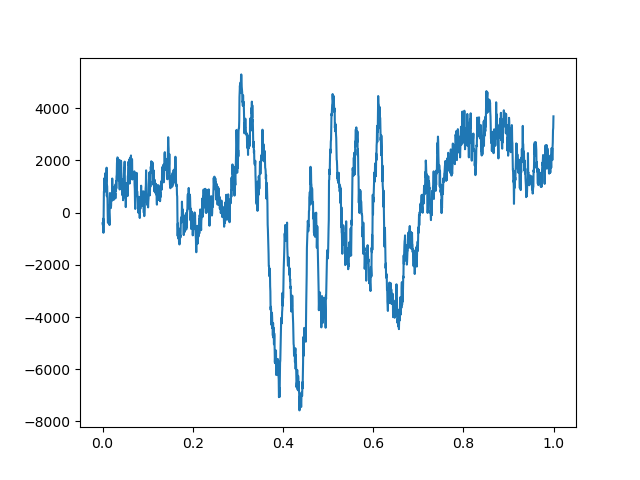

In [98]:
# Defining subset
start = 0
end = 2000

times = np.arange(0, 2000/2000, 1./2000)
tt = times[start:end]
Cortext = TruncAll2[start:end, 4]

plt.close('all')
plt.plot(tt, Cortext)

plt.show()

filename = folder_base / f'M18S1.svg'
plt.savefig(filename, format="svg")

In [ ]:




app = mkQApp()


sample_rate = 2000.
t_start = 0.

TTL = Timestamps

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: TTL, 1: TTL}
#and asign them to some channels each
scatter_channels = {0: [0, 2], 1: [0, 1]}
source = AnalogSignalSourceWithScatter(All2, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.0000002
view1.by_channel_params['ch1', 'gain'] = 0.00002
view1.by_channel_params['ch2', 'gain'] = 0.00002
view1.by_channel_params['ch3', 'gain'] = 0.00002
view1.by_channel_params['ch4', 'gain'] = 0.00002

view1.by_channel_params['ch0', 'offset'] = 0.2
view1.by_channel_params['ch1', 'offset'] = 0.1
view1.by_channel_params['ch2', 'offset'] = 0.0
view1.by_channel_params['ch3', 'offset'] = -0.1
view1.by_channel_params['ch4', 'offset'] = -0.2



#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec_()

In [66]:
folder_base = Path('/Users/ahay/Documents/DATA/Opto_Calbindin/Vert/20240206/')
filename = folder_base / f'RSPUDSproperties.pkl'
RSP = pd.read_pickle(filename)
filename = folder_base / f'M1UDSproperties.pkl'
M1 = pd.read_pickle(filename)
filename = folder_base / f'S1UDSproperties.pkl'
S1 = pd.read_pickle(filename)

In [67]:
M1 = M1[M1['Duration']>0]
M1 = M1[M1['Duration']<1000]
S1 = S1[S1['Duration']>0]
S1 = S1[S1['Duration']<1000]
RSP = RSP[RSP['Duration']>0]
RSP = RSP[RSP['Duration']<1000]


In [68]:
print(np.mean(M1['Duration']), np.mean(S1['Duration']), np.mean(RSP['Duration']))
print(len(M1['Duration']), len(S1['Duration']), len(RSP['Duration']))
scipy.stats.mannwhitneyu(M1['Duration'], RSP['Duration'])

76.01347995743171 111.49368914532997 110.36791395922026
5638 8319 4463


MannwhitneyuResult(statistic=9159079.5, pvalue=2.9388783734336733e-122)

In [69]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

In [70]:
before = 30 # ms
after = 30 # ms
counterDS = 0
Coupled_DS = list()
unCoupled_DS = list()

nb_DS = len(RSP['Duration'])
print(nb_DS)
for Pspin in range(nb_DS-2):
    ser = pd.Series(RSP["end time"]).astype(int).tolist()
    ser2 = pd.Series(S1["end time"]).astype(int).tolist()
    Combined_DS = take_closest(ser2, ser[Pspin])
    distance = Combined_DS - ser[Pspin]
    if (distance > (- before)) and (distance <  after):
        counterDS = counterDS + 1
        Coupled_DS.append(Pspin)
    else:
        unCoupled_DS.append(Pspin)

print(len(Coupled_DS))
print(len(unCoupled_DS))
print(len(Coupled_DS)/(len(Coupled_DS)+len(unCoupled_DS)))

4463
684
3777
0.15332885003362476


In [38]:
pd.Series(RSP["start time"]).astype(int).tolist()

[9523,
 10303,
 18714,
 38167,
 51102,
 58848,
 61799,
 65448,
 74263,
 83682,
 89558,
 98086,
 99067,
 99903,
 100615,
 101249,
 101706,
 102516,
 104570,
 104733,
 105952,
 108117,
 108384,
 111373,
 114216,
 114298,
 114650,
 114889,
 115303,
 122444,
 123813,
 125825,
 126815,
 127374,
 127945,
 130339,
 130644,
 131028,
 133271,
 134111,
 135457,
 136139,
 137239,
 137607,
 137969,
 138275,
 139142,
 140574,
 140708,
 140813,
 141021,
 142818,
 143250,
 143725,
 145004,
 145449,
 146227,
 146424,
 146844,
 147447,
 147898,
 148244,
 148479,
 149352,
 149679,
 150213,
 151331,
 152218,
 152446,
 152506,
 152782,
 153016,
 153611,
 154283,
 154579,
 156106,
 156808,
 157267,
 160457,
 160904,
 162471,
 163827,
 164349,
 164827,
 165161,
 166392,
 167133,
 167612,
 168288,
 168667,
 174951,
 175067,
 175509,
 175828,
 176173,
 177272,
 177891,
 178767,
 179622,
 179939,
 180595,
 180927,
 181362,
 182423,
 182590,
 182921,
 183409,
 183649,
 183995,
 184326,
 184811,
 185273,
 186275

In [31]:
take_closest([2,40,100], 5)

2